In [1]:
import jieba
from docx import Document
import requests
import os
import pandas as pd
import numpy as np

In [2]:
### 分词

In [3]:
# 读取本地停用词表
stopwords = set(open('cn_stopwords.txt', 'r', encoding='utf-8').read().splitlines())


In [4]:
stopwords

{'$',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '?',
 '_',
 '“',
 '”',
 '、',
 '。',
 '《',
 '》',
 '一',
 '一些',
 '一何',
 '一切',
 '一则',
 '一方面',
 '一旦',
 '一来',
 '一样',
 '一般',
 '一转眼',
 '万一',
 '上',
 '上下',
 '下',
 '不',
 '不仅',
 '不但',
 '不光',
 '不单',
 '不只',
 '不外乎',
 '不如',
 '不妨',
 '不尽',
 '不尽然',
 '不得',
 '不怕',
 '不惟',
 '不成',
 '不拘',
 '不料',
 '不是',
 '不比',
 '不然',
 '不特',
 '不独',
 '不管',
 '不至于',
 '不若',
 '不论',
 '不过',
 '不问',
 '与',
 '与其',
 '与其说',
 '与否',
 '与此同时',
 '且',
 '且不说',
 '且说',
 '两者',
 '个',
 '个别',
 '临',
 '为',
 '为了',
 '为什么',
 '为何',
 '为止',
 '为此',
 '为着',
 '乃',
 '乃至',
 '乃至于',
 '么',
 '之',
 '之一',
 '之所以',
 '之类',
 '乌乎',
 '乎',
 '乘',
 '也',
 '也好',
 '也罢',
 '了',
 '二来',
 '于',
 '于是',
 '于是乎',
 '云云',
 '云尔',
 '些',
 '亦',
 '人',
 '人们',
 '人家',
 '什么',
 '什么样',
 '今',
 '介于',
 '仍',
 '仍旧',
 '从',
 '从此',
 '从而',
 '他',
 '他人',
 '他们',
 '以',
 '以上',
 '以为',
 '以便',
 '以免',
 '以及',
 '以故',
 '以期',
 '以来',
 '以至',
 '以至于',
 '以致',
 '们',
 '任',
 '任何',
 '任凭',
 '似的',
 '但',
 '但凡',
 '但是',
 '何',
 '何以',
 '何况',
 '何处',
 '何时',
 '余外',
 '作为',
 '你',
 '你们'

In [5]:
# 下载停用词表
# url = "https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt"
# stopwords = requests.get(url).text
# stopwords = set(stopwords.splitlines())

In [6]:
# 读取文本文件
def read_text_from_docx(file_path):
    document = Document(file_path)
    text = []
    
    for para in document.paragraphs:
        text.append(para.text)
    
    return "\n".join(text)

In [7]:
# 读取停用词
def preprocess_chinese_text(text):
    # 使用jieba进行分词和词性标注
    words = jieba.cut_for_search(text)
    
    # 过滤停用词和进行词性选择
    filtered_words = [word for word in words if word not in stopwords]  

    return filtered_words

In [8]:
def process_documents(directory, output_filename):
    """处理目录下的所有.docx文件，并保存分词结果到CSV文件中。"""
    data = []
    documents_name = []
    for filename in os.listdir(directory):
        if filename.endswith(".docx"):
            file_path = os.path.join(directory, filename)
            text = read_text_from_docx(file_path)
            segmented_text = preprocess_chinese_text(text)
            data.append({'filename': filename, 'text': segmented_text})
            documents_name.append(filename)
    
    # 将数据转换成DataFrame并保存到CSV文件
    df = pd.DataFrame(data)
    df.to_csv(output_filename, index=False, encoding='utf-8')
    
    return documents_name

In [11]:
# 指定包含.docx文件的目录和输出CSV文件的路径
directory = "技术1"
output_filename = "segmented_text.csv"

In [12]:
# 处理指定目录中的所有.docx文件并将结果保存为CSV
document_names = process_documents(directory, output_filename)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LIUYIN~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.422 seconds.
Prefix dict has been built successfully.


In [13]:
### LDA建模

In [14]:
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel

In [15]:
def load_data(file_path):
    """从CSV文件加载数据。"""
    df = pd.read_csv(file_path)
    # 假设CSV文件中每行包含一个文档的分词文本
    # 将字符串形式的列表转换为真正的列表
    df['text'] = df['text'].apply(eval)
    return df['text'].tolist()

In [16]:
def prepare_corpus(documents):
    """准备语料库和词典，用于LDA模型。"""
    # 创建字典
    dictionary = corpora.Dictionary(documents)
    # 使用字典转换文本数据为词袋模型
    corpus = [dictionary.doc2bow(text) for text in documents]
    return dictionary, corpus

In [17]:
def lda_model(corpus, dictionary, num_topics=5):
    """训练LDA模型并返回。"""
    # 设置训练LDA模型的参数
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=30, random_state=42)
    return lda


In [18]:
# 加载数据
file_path = 'segmented_text.csv'
documents = load_data(file_path)

In [19]:
documents

[['技术',
  '革命',
  '正在',
  '改变',
  '生活',
  '方式',
  '新',
  '技术',
  '带来',
  '前所',
  '未有',
  '前所未有',
  '便利',
  '效率'],
 ['现代',
  '技术',
  '人工',
  '智能',
  '人工智能',
  '数据',
  '正在',
  '推动',
  '科技',
  '进步',
  '科技进步',
  '影响',
  '社会',
  '层面'],
 ['技术',
  '教育',
  '领域',
  '教育领域',
  '应用',
  '越来',
  '越来越',
  '广泛',
  '互联',
  '联网',
  '互联网',
  '课堂',
  '智能',
  '教学',
  '工具',
  '技术',
  '正在',
  '彻底',
  '改变',
  '彻底改变',
  '教育',
  '模式'],
 ['新',
  '技术',
  '遥控',
  '手术',
  '系统',
  '数字',
  '数字化',
  '医疗',
  '记录',
  '正在',
  '革新',
  '传统',
  '医疗',
  '提高',
  '治疗',
  '效率'],
 ['技术',
  '进步',
  '经济',
  '增长',
  '重要',
  '驱动',
  '动力',
  '驱动力',
  '尤其',
  '自动',
  '自动化',
  '网络',
  '技术',
  '领域',
  '应用'],
 ['技术',
  '发展',
  '正在',
  '引导',
  '社会',
  '变革',
  '社会变革',
  '多个',
  '方面',
  '特别',
  '通信',
  '信息',
  '传播',
  '方式'],
 ['环保',
  '技术',
  '如可',
  '再生',
  '能源',
  '再生能源',
  '节能',
  '设备',
  '正在',
  '帮助',
  '减少',
  '环境',
  '污染',
  '环境污染',
  '技术',
  '实现',
  '持续',
  '发展',
  '关键'],
 ['现代',
  '农业',
  '现代农业',
  '技术',
  '包括',
  '精密',
  '农业',
  '遗

In [20]:
# 准备语料库和字典
dictionary, corpus = prepare_corpus(documents)

In [21]:
# 训练LDA模型
num_topics = 5
lda = lda_model(corpus, dictionary, num_topics=num_topics)

In [22]:
lda.print_topics()

[(0,
  '0.030*"改变" + 0.029*"农业" + 0.029*"技术" + 0.016*"方式" + 0.016*"包括" + 0.016*"生活" + 0.016*"现代" + 0.016*"提高" + 0.016*"习惯" + 0.016*"工作"'),
 (1,
  '0.041*"正在" + 0.041*"技术" + 0.031*"智能" + 0.031*"建筑" + 0.021*"效率" + 0.021*"系统" + 0.021*"交通" + 0.021*"医疗" + 0.012*"方式" + 0.012*"创新"'),
 (2,
  '0.045*"技术" + 0.031*"重要" + 0.031*"全球" + 0.017*"领域" + 0.017*"自动" + 0.017*"进步" + 0.017*"应用" + 0.017*"驱动力" + 0.017*"自动化" + 0.017*"驱动"'),
 (3,
  '0.047*"技术" + 0.040*"正在" + 0.032*"智能" + 0.032*"影响" + 0.024*"社会" + 0.024*"人工" + 0.024*"人工智能" + 0.017*"发展" + 0.017*"变革" + 0.017*"进步"'),
 (4,
  '0.068*"技术" + 0.028*"正在" + 0.015*"数据" + 0.015*"新" + 0.015*"教育" + 0.015*"发展" + 0.015*"金融" + 0.015*"广泛" + 0.015*"应用" + 0.015*"系统"')]

In [23]:
### 评价LDA模型 ###

In [24]:
#计算coherence score
def coherence(num_topics):
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=30, random_state=42)
    coherence_model_lda = models.CoherenceModel(model=lda, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda


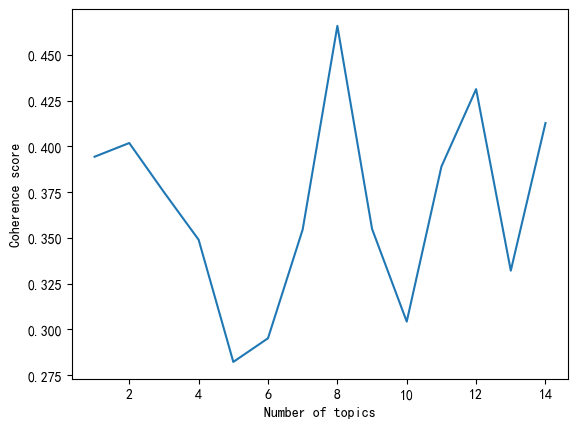

In [25]:
# 绘制主题-coherence曲线
import matplotlib.pyplot as plt
import matplotlib
x = range(1,15)
y = [coherence(i) for i in x]
plt.plot(x,y)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
plt.show()

In [26]:
max(zip(x,y),key=lambda pair:pair[1]) [0]

8

In [27]:
# 以最优主题数8来训练LDA模型
num_topics = 8
lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=30, random_state=42)

In [28]:
lda.print_topics()

[(0,
  '0.036*"改变" + 0.036*"农业" + 0.036*"技术" + 0.019*"方式" + 0.019*"现代" + 0.019*"包括" + 0.019*"生活" + 0.019*"提高" + 0.019*"现代农业" + 0.019*"遗传工程"'),
 (1,
  '0.052*"技术" + 0.040*"正在" + 0.027*"智能" + 0.027*"系统" + 0.027*"医疗" + 0.027*"改变" + 0.027*"交通" + 0.027*"教育" + 0.014*"创新" + 0.014*"效率"'),
 (2,
  '0.055*"技术" + 0.037*"智能" + 0.020*"社会" + 0.020*"自动" + 0.020*"领域" + 0.020*"塑造" + 0.020*"联网" + 0.020*"应用" + 0.020*"未来" + 0.020*"各行"'),
 (3,
  '0.041*"技术" + 0.028*"智能" + 0.028*"影响" + 0.028*"进步" + 0.028*"人工" + 0.028*"人工智能" + 0.028*"正在" + 0.015*"新" + 0.015*"不断" + 0.015*"面对"'),
 (4,
  '0.067*"技术" + 0.034*"正在" + 0.023*"系统" + 0.023*"发展" + 0.023*"金融" + 0.012*"驾驶" + 0.012*"无人驾驶" + 0.012*"无人" + 0.012*"飞行器" + 0.012*"旅行"'),
 (5,
  '0.052*"技术" + 0.052*"建筑" + 0.035*"数据" + 0.019*"新" + 0.019*"效率" + 0.019*"数字" + 0.019*"应用" + 0.019*"广泛" + 0.019*"凸显" + 0.019*"安全"'),
 (6,
  '0.037*"正在" + 0.037*"发展" + 0.037*"技术" + 0.020*"方式" + 0.020*"实现" + 0.020*"帮助" + 0.020*"环境" + 0.020*"减少" + 0.020*"污染" + 0.020*"能源"'),
 (7,
  '0.042*"全球" +

In [29]:
### 储存主题分布 ###

In [30]:
lda.get_document_topics(corpus[1],minimum_probability=0.0)

[(0, 0.008336345),
 (1, 0.008337688),
 (2, 0.008341024),
 (3, 0.9416328),
 (4, 0.008337231),
 (5, 0.008339456),
 (6, 0.008337947),
 (7, 0.0083375)]

In [31]:
### 获取每个文档的主题分布
def get_topic_distribution(lda, corpus):
    topic_distribution = []
    for doc in corpus:
        topic_distribution.append(lda.get_document_topics(doc,minimum_probability=0.0))
    return topic_distribution

In [32]:
### 保存主题分布到文件

def save_topic_distribution(lda, corpus, output_filename):
    topic_distribution = get_topic_distribution(lda, corpus)
    df = pd.DataFrame(topic_distribution)
    df.to_csv(output_filename, index=False)

In [33]:
output_filename = 'topic_distribution.csv'
save_topic_distribution(lda, corpus, output_filename)

In [34]:
### 主题可视化 ###

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.save_html(data, 'lda.html')

In [35]:
### 计算文档之间的主题距离 ###

In [36]:
def calculate_topic_distance_abs_diff(doc_topics_i, doc_topics_j):
    # 保证每个主题的概率被考虑到，即使某些主题在某文档中的概率为0
    # 将主题分布转换为字典形式
    topic_dist_i = dict(doc_topics_i)
    topic_dist_j = dict(doc_topics_j)
    
    # 获取所有主题的并集
    all_topics = set(topic_dist_i.keys()).union(set(topic_dist_j.keys()))
    distance = sum(abs(topic_dist_i.get(topic, 0) - topic_dist_j.get(topic, 0)) for topic in all_topics)
    return distance

In [37]:
doc_topics = get_topic_distribution(lda, corpus)

In [38]:
# 选择两个文档计算它们之间的距离
doc_index1, doc_index2 = 0, 1  # 选择文档索引
distance = calculate_topic_distance_abs_diff(doc_topics[doc_index1], doc_topics[doc_index2])
print(f"Distance between Document {doc_index1} and Document {doc_index2}: {distance}")

Distance between Document 0 and Document 1: 1.8666093479841948


In [39]:
# 计算所有文档之间的主题距离 

def calculate_all_topic_distances(doc_topics):
    num_docs = len(doc_topics)
    distances = [[0] * num_docs for _ in range(num_docs)]
    
    for i in range(num_docs):
        for j in range(i+1, num_docs):
            distance = calculate_topic_distance_abs_diff(doc_topics[i], doc_topics[j])
            distances[i][j] = distances[j][i] = distance
    
    return distances

In [40]:
### 结合主题距离的PageRank计算 ###

In [41]:
# 将主题距离转换为相似度
# 阈值threshold用于确定两个文档之间是否存在链接，按需调整
def convert_distance_to_similarity(distances, threshold=0.1):
    max_distance = max(max(row) for row in distances if row)
    similarity_matrix = []
    links = []
    for i, row in enumerate(distances):
        new_row = []
        link_row = []
        for j, dist in enumerate(row):
            similarity = 1 - (dist / max_distance) if max_distance else 1
            new_row.append(similarity)
            if similarity > threshold and i != j:
                link_row.append(j)
        similarity_matrix.append(new_row)
        links.append(link_row)
    return similarity_matrix, links

In [42]:
# 计算PageRank
def page_rank(links, similarities, alpha=0.85, convergence_threshold=0.0001):
    N = len(links)
    pr = np.ones(N) / N  # 初始均等分配PageRank
    change = 1
    while change > convergence_threshold:
        new_pr = np.zeros(N)
        for i in range(N):
            link_contributions = 0
            for j in links[i]:  # 遍历节点i的所有出链节点j
                if len(links[j]) > 0:  # 避免除以零
                    link_contributions += pr[j] * similarities[i][j] / len(links[j])
            new_pr[i] = (1 - alpha) / N + alpha * link_contributions
        change = np.linalg.norm(new_pr - pr)
        pr = new_pr
    return pr

In [43]:
distances = calculate_all_topic_distances(doc_topics)

In [44]:
similarities, links = convert_distance_to_similarity(distances)

In [62]:
pr = np.ones(20) / 20

In [64]:
temp = links[0]
temp

[6, 10, 13]

In [65]:
pr[temp] * similarities[0][temp] / len(links[temp])

TypeError: list indices must be integers or slices, not list

In [45]:
pr = page_rank(links, similarities)

In [126]:
pr

array([0.04735765, 0.04763616, 0.04689277, 0.04709074, 0.04910225,
       0.04736127, 0.04735799, 0.04464005, 0.04910225, 0.04704355,
       0.04735777, 0.04464005, 0.04562168, 0.04735798, 0.04562168,
       0.04782034, 0.04371549, 0.0478203 , 0.04736127, 0.04371549])

In [133]:
# 按PageRank值对文档进行排序
pagerank_score = pr
doc_pagerank = list(zip(document_names, pagerank_score))

# 按PageRank分数降序排序
sorted_doc_pagerank = sorted(doc_pagerank, key=lambda x: x[1], reverse=True)


In [134]:
# 打印排序后的结果
for doc_name, pr_score in sorted_doc_pagerank:
    print(f"{doc_name}: {pr_score}")

05_技术进步对经济的推动.docx: 0.049102245001964855
09_智能技术的未来.docx: 0.049102245001964855
16_技术对教育的长远影响.docx: 0.047820344149153385
18_未来技术的道德挑战.docx: 0.047820303224359165
02_现代技术的发展.docx: 0.04763615585682232
06_技术和社会变革.docx: 0.04736126712632031
19_技术与环境的可持续发展.docx: 0.04736126712632031
07_技术与环境保护.docx: 0.04735799429624906
14_技术在金融服务中的应用.docx: 0.047357977429094596
11_技术在航空业的革新.docx: 0.04735777101986423
01_技术革命.docx: 0.04735765325994341
04_技术在医疗中的应用.docx: 0.04709074491038974
10_技术在交通领域的变革.docx: 0.04704354698345835
03_技术与教育.docx: 0.046892765390645234
13_数字技术与数据安全.docx: 0.04562168318929323
15_技术在建筑行业的应用.docx: 0.04562168318929323
08_技术在农业中的应用.docx: 0.044640049803254464
12_技术推动的社会变化.docx: 0.044640049803254464
17_技术与文化的互动.docx: 0.04371549433757595
20_技术在全球治理中的作用.docx: 0.04371549433757595


In [135]:
### 结合点击率（CTR）分析 ###

In [136]:
# 假设 clicks 是上传的点击次数数组
clicks = np.array([5, 10, 15, 20, 25, 5, 10, 15, 20, 25, 5, 10, 15, 20, 25, 5, 10, 15, 20, 25])

In [137]:
# 将点击次数转换为点击率（CTR）
# 这里假设每个文档都展示了相同的次数，CTR = 点击次数 / 最大点击次数
max_clicks = np.max(clicks)
ctr = clicks / max_clicks  # 归一化点击次数作为CTR的简化模型

In [138]:
# 结合PageRank和CTR计算最终排序
def page_rank_with_ctr(links, similarities, ctr, alpha=0.85, beta=0.7, convergence_threshold=0.0001):
    N = len(links)
    pr = np.ones(N) / N  # 初始均等分配PageRank
    change = 1
    while change > convergence_threshold:
        new_pr = np.zeros(N)
        for i in range(N):
            link_contributions = 0
            for j in links[i]:  # 遍历节点i的所有出链节点j
                if len(links[j]) > 0:  # 避免除以零
                    link_contributions += pr[j] * similarities[i][j] / len(links[j])
            new_pr[i] = (1 - alpha) / N + alpha * (beta * link_contributions + (1 - beta) * ctr[i])
        change = np.linalg.norm(new_pr - pr)
        pr = new_pr
    return pr


In [139]:
pr_with_ctr = page_rank_with_ctr(links, similarities, ctr)

In [140]:
# 按PageRank值对文档进行排序
pagerank_score = pr_with_ctr
doc_pagerank = list(zip(document_names, pagerank_score))

# 按PageRank分数降序排序
sorted_doc_pagerank = sorted(doc_pagerank, key=lambda x: x[1], reverse=True)

# 打印排序后的结果
for doc_name, pr_score in sorted_doc_pagerank:
    print(f"{doc_name}: {pr_score}")

05_技术进步对经济的推动.docx: 0.5982815111659525
09_智能技术的未来.docx: 0.5662692123296404
10_技术在交通领域的变革.docx: 0.5532553325503654
15_技术在建筑行业的应用.docx: 0.5413168746404556
04_技术在医疗中的应用.docx: 0.514284435289849
20_技术在全球治理中的作用.docx: 0.490739647671717
13_数字技术与数据安全.docx: 0.4769519371608439
03_技术与教育.docx: 0.47306331518324524
17_技术与文化的互动.docx: 0.3938788115605513
19_技术与环境的可持续发展.docx: 0.37654699032312317
14_技术在金融服务中的应用.docx: 0.35159580148738084
08_技术在农业中的应用.docx: 0.3390914285460864
12_技术推动的社会变化.docx: 0.3068562652191356
18_未来技术的道德挑战.docx: 0.3065602217658953
06_技术和社会变革.docx: 0.280263869022289
02_现代技术的发展.docx: 0.2664634794718822
07_技术与环境保护.docx: 0.2662616200698216
16_技术对教育的长远影响.docx: 0.2279475870318303
01_技术革命.docx: 0.22391680898076105
11_技术在航空业的革新.docx: 0.22370140310203912
